In [1]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from Systems.DuffingSystem import *
from Systems.Generate_Data import *
from HamiltonianNeuralNetwork.pHNN import *
from NumericalIntegration.Numerical_Integration import *
from HamiltonianNeuralNetwork.Train import *
torch.random.manual_seed(1)
np.random.seed(33)
mps_device = torch.device("mps")

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [2]:
def initial_condition():
    def sampler():
        u0 =  np.random.rand(2) * 2 - 1
        radius = np.sqrt(np.random.uniform(0.5, 1.5))  
        u0 /= np.sqrt((u0 ** 2).sum()) * (radius)
        #u0 = np.random.rand(2)*0
        return u0.flatten()
    return sampler()

In [3]:
"""

def generate_data(ntrajectories, t_sample,system,integrator, true_derivatives = False,H0=None,u0s=None,data_type = torch.float32):
    #Parameters
    nstates = system.nstates
    traj_length = t_sample.shape[0] 

    #Initializing 
    u = np.zeros((ntrajectories,traj_length,nstates))
    dudt = np.zeros_like(u)
    t = np.zeros((ntrajectories,traj_length))

    u0_ = np.zeros((ntrajectories,nstates))

    for i in tqdm(range(ntrajectories)):
        if u0s is not None:
            u0 = np.array(u0s[i])
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,u0=u0,integrator=integrator)
        else:
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,integrator=integrator)
    
    #Reshaping
    dt = torch.tensor([t[0, 1] - t[0, 0]], dtype=data_type)
    u_start = torch.tensor(u[:, :-1], dtype=data_type).reshape(-1, nstates)
    u_end = torch.tensor(u[:, 1:], dtype=data_type).reshape(-1, nstates)
    t_start = torch.tensor(t[:, :-1], dtype=data_type).reshape(-1, 1)
    dt = dt * torch.ones_like(t_start, dtype=data_type)

    if true_derivatives:
        dudt = torch.tensor(dudt[:, :-1], dtype=data_type).reshape(-1, 1, nstates)
    else:
        dudt = (u_end - u_start).clone().detach() / dt[0, 0]

    u_exact = u
    return (u_start, u_end,t_start, dt), dudt, u_exact, u0_

"""

'\n\ndef generate_data(ntrajectories, t_sample,system,integrator, true_derivatives = False,H0=None,u0s=None,data_type = torch.float32):\n    #Parameters\n    nstates = system.nstates\n    traj_length = t_sample.shape[0] \n\n    #Initializing \n    u = np.zeros((ntrajectories,traj_length,nstates))\n    dudt = np.zeros_like(u)\n    t = np.zeros((ntrajectories,traj_length))\n\n    u0_ = np.zeros((ntrajectories,nstates))\n\n    for i in tqdm(range(ntrajectories)):\n        if u0s is not None:\n            u0 = np.array(u0s[i])\n            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,u0=u0,integrator=integrator)\n        else:\n            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,integrator=integrator)\n    \n    #Reshaping\n    dt = torch.tensor([t[0, 1] - t[0, 0]], dtype=data_type)\n    u_start = torch.tensor(u[:, :-1], dtype=data_type).reshape(-1, nstates)\n    u_end = torch.tensor(u[:, 1:], dtype=data_type).reshape(-1, nstates)\n    t_start =

### Looking at data

In [4]:
T_max_train = 18000
alpha, beta, omega, gamma, delta = -1, 1, 1.4, 0.39, 0.1
dt_per_period = 100
nsamples_train = 18000/(2 * np.pi / omega / dt_per_period)
ntraj_train = 1

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)


In [5]:
"""
integrator = "midpoint"

sys = DuffingSystem(alpha = alpha, beta = beta, omega = omega, delta = delta, gamma=gamma)

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end,t_start, dt), dudt

pstep = 100
plt.scatter(u_train[0][::pstep,0],u_train[0][::pstep,1])
"""

'\nintegrator = "midpoint"\n\nsys = DuffingSystem(alpha = alpha, beta = beta, omega = omega, delta = delta, gamma=gamma)\n\n(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)\ntrain_data = (u_start, u_end,t_start, dt), dudt\n\npstep = 100\nplt.scatter(u_train[0][::pstep,0],u_train[0][::pstep,1])\n'

In [6]:
"""

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange
import datetime


def Batch_Data(data,batch_size,shuffle):
    #Power of 2
 
    nsamples = data[1].shape[0]

    if shuffle:
        permutation = torch.randperm(nsamples)
    else:
        permutation = torch.arange(nsamples)

    nbatches = np.ceil(nsamples/batch_size).astype(int)
    batched = [(None,None)] *nbatches  #((x_start, x_end, t_start, t_end, dt, u), dxdt)

    for i in range(nbatches):
        indices = permutation[i * batch_size : (i + 1) * batch_size]
        input_tuple = [data[0][j][indices] for j in range(len(data[0]))]
        dudt = data[1][indices]
        batched[i] = (input_tuple, dudt)

    return batched


def penalty_loss(model,time, lam_F=1e-4,lam_N=1e-4):
    penalty = 0
    penalty += lam_F*torch.mean(torch.abs(model.External_Force(time.reshape(-1,1))))
    penalty += lam_N*torch.mean(torch.abs(model.Get_N()))
    return penalty

def train_one_epoch(model,batched_train_data,loss_func,optimizer,integrator):
    computed_loss = 0.0
    optimizer.zero_grad()
    for input_tuple, dudt in batched_train_data:
      
        (u_start, u_end, t_start, dt) = input_tuple
        n,m = u_start.shape
        #Reshaping
        if n ==1:
            u_start = u_start.view(-1)

        dudt = dudt.view(n,m)
        #Estimating dudt
 

        dudt_est = model.time_derivative_step(integrator = integrator, u_start = u_start,t_start = t_start,u_end = u_end,dt = dt)
        loss = loss_func(dudt_est,dudt)
        loss += penalty_loss(model,t_start)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        computed_loss += loss.item()

    return computed_loss / len(batched_train_data)

def compute_validation_loss(model, integrator, val_data, valdata_batched, loss_func):
    val_loss = 0
    if valdata_batched is not None:
        for input_tuple, dudt in valdata_batched:
            (u_start, u_end, t_start, dt) = input_tuple
            n,m = u_start.shape
            #Reshaping
            if n ==1:
                u_start = u_start.view(-1)
            #u_start = u_start.requires_grad_()
            dudt = dudt.view(n,m)
        
            dudt_est = model.time_derivative_step(integrator = integrator, u_start = u_start,t_start = t_start,u_end = u_end,dt = dt)

            val_loss += loss_func(dudt_est, dudt).item()
            val_loss += penalty_loss(model,t_start).item()
    else:
        (u_start, u_end, t_start, dt), dudt = val_data
        n,m = u_start.shape
        #Reshaping
        if n ==1:
            u_start = u_start.view(-1)
        #u_start = u_start.requires_grad_()
        dudt = dudt.view(n,m)
        dudt_est = model.time_derivative(integrator, u_start,u_end,dt)
        val_loss = loss_func(dudt_est, dudt).item()
        val_loss += penalty_loss(model,t_start).item()
    val_loss = val_loss / len(valdata_batched)
    return val_loss#.item() #float(val_loss.detach().numpy())
    

def train(model,integrator, train_data,val_data, optimizer,shuffle,loss_func=torch.nn.MSELoss(),batch_size=1024,epochs = 20, verbose =True):

   
    trainingdetails={}
    train_batch = Batch_Data(train_data, batch_size, shuffle)
    valdata_batched = Batch_Data(val_data, batch_size, False)

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    loss_list = []
    val_loss_list =  []



    with trange(epochs) as steps:
        for epoch in steps:
            if shuffle:
                train_batch = Batch_Data(train_data,batch_size,shuffle)
            model.train(True) 
            start = datetime.datetime.now() 
            avg_loss = train_one_epoch(model,train_batch,loss_func,optimizer,integrator)
            end = datetime.datetime.now() 
  
            loss_list.append(avg_loss)
            model.train(False) 
            if verbose: #Print
                steps.set_postfix(epoch=epoch, loss=avg_loss)

            if val_data is not None:
                start = datetime.datetime.now()
                vloss = compute_validation_loss(model, integrator, val_data, valdata_batched, loss_func)
                end = datetime.datetime.now()
               
                val_loss_list.append(vloss)

            trainingdetails["epochs"] = epoch + 1
            trainingdetails["val_loss"] = vloss
            trainingdetails["train_loss"] = avg_loss



    print(val_loss_list)
    print(loss_list)
     # Plot the loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(loss_list, label = "Training Loss")
    plt.plot(val_loss_list,label = "Validation Loss")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    shape_data = (len(train_batch),train_batch[0][0][0].shape)

    return model,trainingdetails

"""

'\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nimport torch\nfrom tqdm import trange\nimport datetime\n\n\ndef Batch_Data(data,batch_size,shuffle):\n    #Power of 2\n \n    nsamples = data[1].shape[0]\n\n    if shuffle:\n        permutation = torch.randperm(nsamples)\n    else:\n        permutation = torch.arange(nsamples)\n\n    nbatches = np.ceil(nsamples/batch_size).astype(int)\n    batched = [(None,None)] *nbatches  #((x_start, x_end, t_start, t_end, dt, u), dxdt)\n\n    for i in range(nbatches):\n        indices = permutation[i * batch_size : (i + 1) * batch_size]\n        input_tuple = [data[0][j][indices] for j in range(len(data[0]))]\n        dudt = data[1][indices]\n        batched[i] = (input_tuple, dudt)\n\n    return batched\n\n\ndef penalty_loss(model,time, lam_F=1e-4,lam_N=1e-4):\n    penalty = 0\n    penalty += lam_F*torch.mean(torch.abs(model.External_Force(time.reshape(-1,1))))\n    penalty += lam_N*torch.mean(torch.abs(model.Get_N()))\n    return penalty\n\

In [7]:
"""
T_max_train = 2*np.pi
chaos = False
if chaos == True:
    alpha, beta, omega, gamma, delta = 1, 1, 1.4, 0.39, 0.1 
else:
    alpha, beta, omega, gamma, delta = -1, 1, 1.2, 0.2, 0.3
nsamples_train = 100*T_max_train/2
ntraj_train =  1750#700# 70
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750#300#30
epochs = 50

"""

#same as in paper

T_max_train = 10.01
chaos = False
if chaos == True:
    alpha, beta, omega, gamma, delta = 1, 1, 1.4, 0.39, 0.1 
else:
    alpha, beta, omega, gamma, delta = -1, 1, 1.2, 0.2, 0.3
nsamples_train = 100*T_max_train/2
ntraj_train =  750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 250
epochs = 50



batch_size = 64
lr = 1e-3

act_1 = PAU()
act_2 = PAU()
act_3 = nn.Softplus()



sys = DuffingSystem(alpha = alpha, beta = beta, omega = omega, delta = delta, gamma=gamma)

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

In [8]:
def Duffing_H_loss_func(dudt,dudt_est):
    func = torch.nn.MSELoss()
    MSE_dudt = func(dudt_est,dudt)
    return MSE_dudt


def Duffing_penalty_loss_func(model,time, lam_F=1e-4,lam_N=1e-4):
    penalty = 0
    penalty += lam_F*torch.mean(torch.abs(model.External_Force(time.reshape(-1,1)).detach()))
    penalty += lam_N*torch.mean(torch.abs(model.Get_N().detach()))
    return penalty
"""
def Duffing_penalty_loss_func(model, time, lam_F=1e-4, lam_N=1e-4):
    with torch.no_grad(): 
        F = model.External_Force(time.reshape(-1, 1)).detach()
        N = model.Get_N().detach()
    return lam_F * torch.mean(torch.abs(F)) + lam_N * torch.mean(torch.abs(N))
"""
loss_func = loss_wrapper(Duffing_H_loss_func)
penalty_func = loss_wrapper(Duffing_penalty_loss_func)



In [9]:
integrator = "midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, t_start, dt), dudt


100%|██████████| 250/250 [00:03<00:00, 81.52it/s]


100%|██████████| 50/50 [53:49<00:00, 64.59s/it, epoch=49, loss=4.9e-5] 


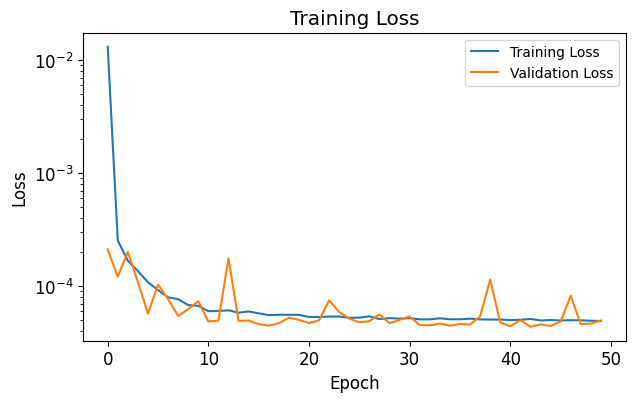

In [11]:
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 2, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 2, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)


model_exp = PortHamiltonianNeuralNetwork(nstates = 2, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)

optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)

trainer = Training(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp, system = sys, batch_size=batch_size,epochs = epochs)
model_exp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func)

100%|██████████| 1/1 [00:00<00:00, 22.19it/s]


u_start = u[i : i + 1, :]:  tensor([[0.5338, 0.6509]])
t_start = t_step:  tensor(0.)
dt:  tensor(0.0100)
dudt[i,:]:  tensor([0.6539, 0.1870], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([0.5403, 0.6528], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[0.5403, 0.6528]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0100)
dt:  tensor(0.0100)
dudt[i,:]:  tensor([0.6557, 0.1892], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([0.5469, 0.6547], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[0.5469, 0.6547]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0200)
dt:  tensor(0.0100)
dudt[i,:]:  tensor([0.6575, 0.1913], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([0.5534, 0.6566], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[0.5534, 0.6566]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0300)
dt:  tensor(0.0100)
dudt[i,:]:  tensor([0.6593, 0.1933], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([0.5600, 0.6585], grad_fn=<SliceBa

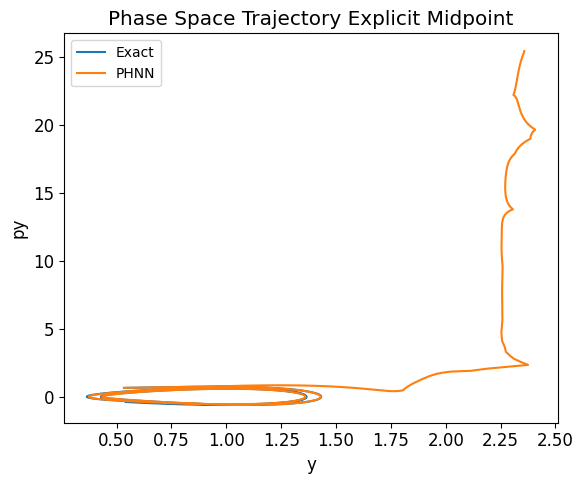

In [ ]:
tmax =  15.01#2.5*np.pi
nsamples = 100*tmax
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_exp[0].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))  
y, py = u_exact[0][:, 0], u_exact[0][:, 1]
ax.plot(y, py, label="Exact")
y, py = u_pred[:, 0], u_pred[:, 1]
ax.plot(y, py, label="PHNN")
ax.set_xlabel("y")
ax.set_ylabel("py")
ax.set_title("Phase Space Trajectory Explicit Midpoint" )
ax.legend()


plt.tight_layout() 
plt.show()

## Symplectic Midpoint

In [16]:
integrator = "symplectic midpoint"

(u_start, u_end, t_start, dt), dudt, u_train, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator, u0s = u0s_train)
train_data = (u_start, u_end,t_start, dt), dudt

(u_start, u_end,t_start, dt), dudt, u_val, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator, u0s = u0s_val)
val_data = (u_start, u_end, t_start, dt), dudt


100%|██████████| 250/250 [00:19<00:00, 12.86it/s]


100%|██████████| 50/50 [1:56:48<00:00, 140.18s/it, epoch=49, loss=4.75e-5]  


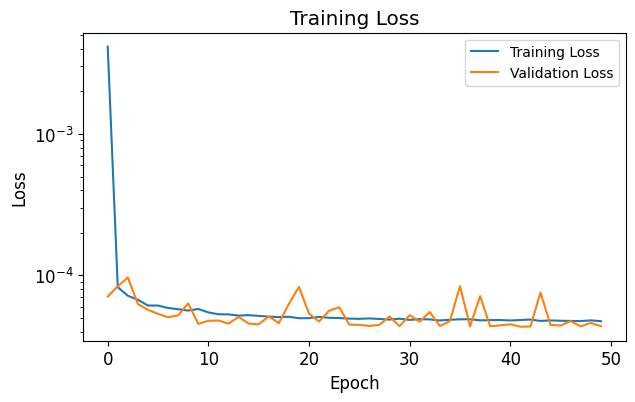

In [18]:
Hamiltonian_est = BaseHamiltonianNeuralNetwork(nstates = 2, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)
External_Forces_est = ExternalForceNeuralNetwork(nstates = 2, act_1 = act_1, act_2 = act_2)#, act_3 = act_3)


model_symp = PortHamiltonianNeuralNetwork(nstates = 2, S = sys.S, Hamiltonian_est = Hamiltonian_est, External_Forces_est = External_Forces_est)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)


trainer = Training(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp, system = sys, batch_size=batch_size,epochs = epochs)
model_symp, trainingdetails_symp = trainer.train(loss_func=loss_func,penalty_func = penalty_func)

100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/HamiltonianNeuralNetwork/pHNN.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/Users/sannejamila/Documents/Vår 2025/Prosjektoppgave/Oppgave_github/HNNs_ODEs/NumericalIntegration/Numerical_Integration.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


u_start = u[i : i + 1, :]:  tensor([[ 0.0930, -0.8413]])
t_start = t_step:  tensor(0.)
dt:  tensor(0.0100)
Jacobian is singular, stopping.
dudt[i,:]:  tensor([-0.8394,  0.3393], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([ 0.0846, -0.8380], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[ 0.0846, -0.8380]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0100)
dt:  tensor(0.0100)
Jacobian is singular, stopping.
dudt[i,:]:  tensor([-0.8361,  0.3326], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([ 0.0763, -0.8346], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[ 0.0763, -0.8346]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0200)
dt:  tensor(0.0100)
Jacobian is singular, stopping.
dudt[i,:]:  tensor([-0.8328,  0.3259], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([ 0.0679, -0.8314], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[ 0.0679, -0.8314]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0300)
dt:  tensor(0.0100)

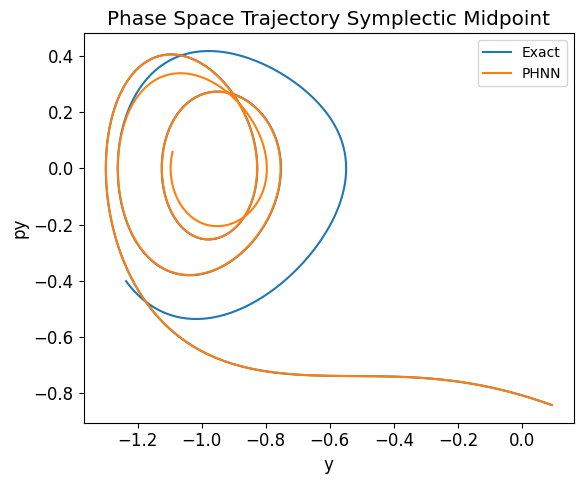

In [19]:
tmax =  15.01#2.5*np.pi
nsamples = 100*tmax
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))  
y, py = u_exact[0][:, 0], u_exact[0][:, 1]
ax.plot(y, py, label="Exact")
y, py = u_pred[:, 0], u_pred[:, 1]
ax.plot(y, py, label="PHNN")
ax.set_xlabel("y")
ax.set_ylabel("py")
ax.set_title("Phase Space Trajectory Symplectic Midpoint" )
ax.legend()


plt.tight_layout() 
plt.show()

In [ ]:
test = np.array([[-0.2084,  0.5009]])


In [ ]:
sys.Hamiltonian(test,t=1.1499)

np.float64(0.10420667838547841)

In [ ]:
sys.Hamiltonian_grad(test,t=1.1499)

array([[0.19934907],
       [0.5009    ]])

In [ ]:
sys.u_dot(test,np.array([1.1499]))

array([[ 0.5009    , -0.15325292]])

In [ ]:
model_symp.Hamiltonian(torch.tensor(test,dtype=torch.float32))

tensor([[-1.1745]], grad_fn=<AddmmBackward0>)

In [ ]:
model_symp.dH(torch.tensor(test,dtype=torch.float32))

tensor([[0.1758, 0.5007]])

In [ ]:
model_symp.u_dot(torch.tensor(test,dtype=torch.float32),torch.tensor([1.1499],dtype=torch.float32))

tensor([[ 0.5007, -0.1541]], grad_fn=<CatBackward0>)

In [ ]:
def newton_torch(func, guess, threshold=1e-7, max_iters=100, damping=1.0):
    guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)
    for i in range(max_iters):
        value = func(guess) 
        if torch.linalg.norm(value) < threshold:
            print("Jippi.")
            return guess
        J = torch.autograd.functional.jacobian(func, guess)  
        try:
            step = torch.linalg.solve(J, -value)  
            print("Jippi.")
        except RuntimeError:
            print("Jacobian is singular, stopping.")
            return guess
        guess = guess + damping * step 
    return guess

In [ ]:
def newton_torch(func, guess, threshold=1e-7, max_iters=100, damping=1.0):
    guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)
    for i in range(max_iters):
        value = func(guess) 
        if torch.linalg.norm(value) < threshold:
            print("Jippi.")
            return guess
        J = torch.autograd.functional.jacobian(func, guess)  
        try:
            step = torch.linalg.solve(J, -value)  
            print("Jippi.")
        except RuntimeError:
            print("Jacobian is singular, stopping.")
            return guess
        guess = guess + damping * step 
    return guess






def symplectic_midpoint_time_derivative_withtime(u_dot,u_start, t_start, dt,u_end = None):
    t_end = t_start + dt/2
    if u_end == None:
        def g(u):
            return u-u_start-dt*u_dot(0.5*(u+u_start),t_end)
        if isinstance(u_start,torch.Tensor):
            original_shape = u_start.shape
            u_start = u_start.squeeze(0) 
            u_end = newton_torch(g,u_start)
            u_mid = 0.5*(u_start + u_end)
            return u_dot(u_mid.view(original_shape), t_end)
        else:
            u_end = newton(g,u_start, tol = 1e-7, maxiter = 1000)
    u_mid = 0.5*(u_start + u_end)
    lhs = u_dot(u_mid, t_end)
    return lhs

In [ ]:
def test_sim_traj(model,t_sample,dt,u0=None):
        if u0 is None:
            u0 = model.initial_condition_sampler()
 
        u0 = torch.tensor(u0,dtype = torch.float32)
        u0 = u0.reshape(1,u0.shape[-1])

        t_sample = torch.tensor(t_sample,dtype = torch.float32)
        #t_shape = t_sample.shape[-1]

        #Initializing solution 
        u = torch.zeros([t_sample.shape[-1],model.nstates])
        dudt = torch.zeros_like(u)

        #Setting initial conditions
        u[0, :] = u0

        #for i in range(t_shape-1):
        for i, t_step in enumerate(t_sample[:-1]):
            dt = t_sample[i + 1] - t_step
          
            dudt[i,:] = symplectic_midpoint_time_derivative_withtime(u_dot = model.u_dot, u_start = u[i : i + 1, :], dt=dt,u_end = None, t_start = t_step )


            u[i+1,:] = u[i,:] + dt*dudt[i,:]
     
        return u,dudt,u0

In [ ]:
def test_sim_traj(model,t_sample,dt,u0=None):
        if u0 is None:
            u0 = model.initial_condition_sampler()
 
        u0 = torch.tensor(u0,dtype = torch.float32)
        u0 = u0.reshape(1,u0.shape[-1])

        t_sample = torch.tensor(t_sample,dtype = torch.float32)
        #t_shape = t_sample.shape[-1]

        #Initializing solution 
        u = torch.zeros([t_sample.shape[-1],model.nstates])
        dudt = torch.zeros_like(u)

        #Setting initial conditions
        u[0, :] = u0

        #for i in range(t_shape-1):
        for i, t_step in enumerate(t_sample[:-1]):
            dt = t_sample[i + 1] - t_step
          
            dudt[i,:] = symplectic_midpoint_time_derivative_withtime(u_dot = model.u_dot, u_start = u[i : i + 1, :], dt=dt,u_end = None, t_start = t_step )


            u[i+1,:] = u[i,:] + dt*dudt[i,:]
     
        return u,dudt,u0

def test_generation(model,ntrajectories, t_sample,u0s=None):
        if u0s is None:
            u0s = model.initial_condition_sampler(ntrajectories)
        
        #Reshaping
        u0s = torch.tensor(u0s,dtype = torch.float32)
        u0s = u0s.reshape(ntrajectories, model.nstates)
        t_sample = torch.tensor(t_sample,dtype = torch.float32)
        if len(t_sample.shape) == 1:
                #Reshaping time
                t_sample = np.tile(t_sample, (ntrajectories, 1))

        dt = t_sample[0, 1] - t_sample[0, 0]
        traj_length = t_sample.shape[-1]

        #Initializng u and setting initial conditions
        u = torch.zeros([ntrajectories, traj_length, model.nstates])
        u[:,0,:] = u0s

        for i in range(ntrajectories):
            u[i] = test_sim_traj(model = model,t_sample = t_sample[i], u0 = u0s[i],dt=dt)[0]
            
   
        return u, t_sample
tmax = 2*np.pi
nsamples = 1000*tmax
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

test_generation(model = model_symp,ntrajectories = ntrajectories, t_sample = t_sample,u0s=u0s)

/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_68052/2245103375.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_68052/1480690111.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singul

KeyboardInterrupt: 

In [ ]:
test_generation(model = model_symp,ntrajectories = ntrajectories, t_sample = t_sample,u0s=u0s)

/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_68052/1304074440.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_68052/2092351003.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singular, stopping.
Jippi.
Jacobian is singul

KeyboardInterrupt: 

In [ ]:
tmax = 10*np.pi
nsamples = 100*tmax
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
integrator = "symplectic midpoint"
ntrajectories = 1

(u_start, u_end, t_start, dt), dudt, u_exact, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

u_pred = u_phnn_symp[0].detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))  
y, py = u_exact[0][:, 0], u_exact[0][:, 1]
ax.plot(y, py, label="Exact")
y, py = u_pred[:, 0], u_pred[:, 1]
ax.plot(y, py, label="PHNN")
ax.set_xlabel("y")
ax.set_ylabel("py")
ax.set_title("Phase Space Trajectory Explicit Midpoint" )
ax.legend()


plt.tight_layout() 
plt.show()

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


u_start = u[i : i + 1, :]:  tensor([[-1.0106,  0.9424]])
t_start = t_step:  tensor(0.)
dt:  tensor(0.0100)
Jacobian is singular, stopping.
dudt[i,:]:  tensor([ 0.9417, -0.2701], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([-1.0012,  0.9397], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[-1.0012,  0.9397]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0100)
dt:  tensor(0.0100)
Jacobian is singular, stopping.
dudt[i,:]:  tensor([ 0.9390, -0.2859], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([-0.9918,  0.9368], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[-0.9918,  0.9368]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0200)
dt:  tensor(0.0100)
Jacobian is singular, stopping.
dudt[i,:]:  tensor([ 0.9363, -0.3003], grad_fn=<SliceBackward0>)
u[i+1,:]:  tensor([-0.9824,  0.9338], grad_fn=<SliceBackward0>)
u_start = u[i : i + 1, :]:  tensor([[-0.9824,  0.9338]], grad_fn=<SliceBackward0>)
t_start = t_step:  tensor(0.0300)
dt:  tensor(0.0100)

KeyboardInterrupt: 